<a href="https://colab.research.google.com/github/tazkia243601/humans_vs_apes_image_classification/blob/main/humans_vs_apes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###import required libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


###import the dataset

In [ ]:
batch_size = 32
img_height = 300
img_width = 300

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'gdrive/MyDrive/the_circle_of_life/img_clas/dataset',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'gdrive/MyDrive/the_circle_of_life/img_clas/dataset',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 200 files belonging to 2 classes.
Using 160 files for training.
Found 200 files belonging to 2 classes.
Using 40 files for validation.


In [ ]:
#testing whether its the correct folder
os.listdir('gdrive/MyDrive/the_circle_of_life/img_clas/dataset')

['white humans', 'gorillas']

###display the dataset

In [ ]:
class_names = train_ds.class_names
print(class_names)

['gorillas', 'white humans']


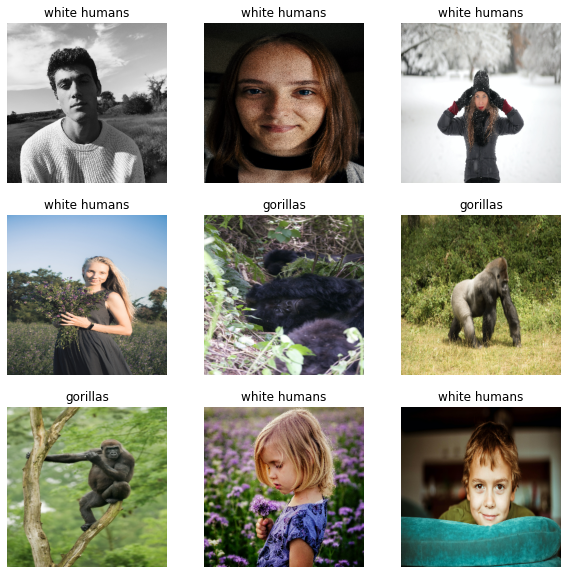

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

###preprocessing

In [ ]:
# Defining a few hyperparameters
# IMG_SIZE = 300
# batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE


# We can define the Resizing and Rescaling
resize_and_rescale = tf.keras.Sequential([
  # tf.keras.layers.experimental.preprocessing.Resizing(img_height, img_width),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

# A function that resizes, rescales, batches and shuffles
def prepare_images(ds, shuffle=False,):
  
  # Resize and rescale the dataset.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  # Shuffles the dataset
  if shuffle:
    ds = ds.shuffle(1000)
  
  # Batch all datasets.
  # ds = ds.batch(batch_size)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
## Let us resize and rescale the images in our dataset
train_ds = prepare_images(train_ds, shuffle=True)
val_ds = prepare_images(val_ds) 

In [ ]:
#info about the images in the dataset
for x,y in train_ds.take(4):
  print(x.shape,y.shape)

(32, 300, 300, 3) (32,)
(32, 300, 300, 3) (32,)
(32, 300, 300, 3) (32,)
(32, 300, 300, 3) (32,)


###training the model

In [ ]:
## A simple CNN based model
def create_cnn_model():
  model = tf.keras.Sequential([
                tf.keras.layers.Conv2D(16, (2,2), activation='relu', input_shape=(img_height, img_width, 3)),
                tf.keras.layers.MaxPool2D(2,2),
                tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
                tf.keras.layers.MaxPool2D(2,2),
                tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
                tf.keras.layers.MaxPool2D(2,2),
                tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
                tf.keras.layers.MaxPool2D(2, 2),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(512, activation='relu'),
                tf.keras.layers.Dense(2, activation='softmax')
]) 
#the last layer has this:
#tf.keras.layers.Dense(2, activation='softmax')
#the 2 is there bcuz i have 2 classes if i have more the 2 needs to be changed

  model.compile(loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'],
                      optimizer='adam'
                      )
  return model

In [ ]:
# create model
model = create_cnn_model()

# Early Stopping callback
ES = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights='True'
)

In [ ]:
# Train the model
model.fit(train_ds, #train_ds,
          epochs=10,
          validation_data=val_ds,
          callbacks=[ES]
          )



Epoch 1/10
5/5 [==============================] - 34s 3s/step - loss: 1.8955 - accuracy: 0.5250 - val_loss: 0.9537 - val_accuracy: 0.5000
Epoch 2/10
5/5 [==============================] - 33s 4s/step - loss: 0.9025 - accuracy: 0.5000 - val_loss: 0.6755 - val_accuracy: 0.5000
Epoch 3/10
5/5 [==============================] - 36s 4s/step - loss: 0.6907 - accuracy: 0.4938 - val_loss: 0.6807 - val_accuracy: 0.5000
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.5437

###inference function

In [ ]:
def inference_function(image_path):
  """
  image_path (str): path of the image file

  returns index, probability
  img (PIL.Image.Image): the image from the image_path
  index (int): the class the image belongs to
  probability (float): the probability for that class
  """

  img = tf.keras.utils.load_img(
      image_path, target_size=(img_height,img_width) # MODIFY IMAGE HEIGHT AND WIDTH
  )

  # convert the img to an array. Refer to documentation: https://www.tensorflow.org/api_docs/python/tf/keras/utils/img_to_array
  img_array = tf.keras.utils.img_to_array( #mycode
    img, data_format=None, dtype=None
  )

  # apply your rescaling preprocessing step
  img_array = img_array*(1./255)

  # create a batch
  img_array = tf.expand_dims(img_array, 0)

  # run the img_array through your model. Hint: use the model.predict() function
  predictions = model.predict(img_array) #mycode

  # remove batch
  pred = np.squeeze(predictions)
  
  # index of the highest probability element of pred array. 
  # Hint 1: use argmax function: https://numpy.org/doc/stable/reference/generated/numpy.argmax.html
  # Hint 2: printing and seeing what the pred array looks like may help you
  index = np.argmax(pred) #mycode
  
  # highest probability in pred array
  probability = np.amax(pred) #mycode


  return img, index, probability

1/1 [==============================] - 0s 85ms/step
gorillas 0.9596787


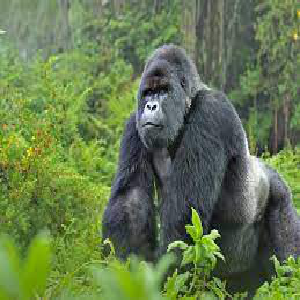

In [ ]:
# run the inference function on your test image
img, class_index, class_probability = inference_function("/content/gorilla1.jpeg") #partly my code

# if class_index == 0:
#   class_name = "gorilla"
# elif class_index == 1:
#   class_name = "white man"

# name of the class the image belongs to
class_name = class_names[class_index]

print(class_name, class_probability)
img